In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error

import numpy as np

In [2]:
params = {
    'test_size': 0.2,
    'random_state': 1337,
    'validation_split': 0.2
}

In [3]:
df = pd.read_parquet("../data/qsc_out.random_scan_nfp2.parquet")

In [4]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y0,y1,y2,y3,y4,y5,y6
0,0.133438,-0.092950,0.011193,-0.005795,0.000771,-0.000122,-0.713354,0.129141,1.482134,0.213466,0.241207,0.475203,0.852697,1.067530,0.342066
1,0.106896,0.107480,0.007474,0.007549,0.000577,0.000333,-0.718440,-0.309748,1.711563,0.178743,0.181471,0.403228,0.821898,1.052911,0.333320
2,0.100286,0.098256,0.006654,0.006411,0.000179,0.000225,-0.775836,0.064299,1.895026,0.154513,0.204983,0.335392,0.807669,0.965668,0.331046
3,0.120435,0.114909,0.009287,0.008526,0.000167,0.000237,-0.767415,0.016524,1.380982,0.196482,0.304152,0.364896,0.833857,1.286199,0.337564
4,-0.128050,0.160498,0.009165,-0.010457,-0.000347,0.000200,-0.719544,0.569769,0.962259,0.304666,0.529468,0.435512,0.834355,1.311465,0.340612


In [5]:
df.shape

(1000000, 15)

In [6]:
x_columns = [col for col in df.columns if col.startswith('x')]
y_columns = [col for col in df.columns if col.startswith('y')]

Y = df[y_columns].values
X = df[x_columns].values

In [7]:
def preprocess_data(X_train, X_test, Y_train, Y_test, params):
    scaler_x = StandardScaler()
    scaler_x = scaler_x.fit(X_train)
    scaler_y = StandardScaler()
    scaler_y = scaler_y.fit(Y_train)
    X_train = scaler_x.transform(X_train)
    X_test = scaler_x.transform(X_test)
    Y_train = scaler_y.transform(Y_train)
    Y_test = scaler_y.transform(Y_test)

    input_shape = X_train.shape[1]
    
    output_shape = Y_train.shape[1]
    return X_train, X_test, Y_train, Y_test, input_shape, output_shape, scaler_x, scaler_y

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=params['test_size'], 
                                                    random_state=params['random_state'])

X_train, X_test, Y_train, Y_test, input_shape, output_shape, scaler_x, scaler_y = preprocess_data(X_train, X_test, Y_train, Y_test, params)

In [8]:
X_train.mean(axis=0), X_train.std(axis=0) 

(array([-1.1327621e-08,  2.1925195e-09, -5.5531042e-09,  7.3113129e-09,
        -1.3621244e-09,  3.0783935e-09,  1.1375323e-08, -3.8778780e-09],
       dtype=float32),
 array([0.9993136 , 0.99944884, 0.99930733, 0.9995662 , 0.99942106,
        0.999486  , 0.9999612 , 0.9995944 ], dtype=float32))

## Appears to be drift, perhaps the sample is not big enough

In [9]:
X_test.mean(axis=0), X_test.std(axis=0) 

(array([-0.00667486,  0.00326206, -0.00185904, -0.00032165, -0.00151821,
        -0.0017868 , -0.00261114,  0.00337474], dtype=float32),
 array([0.99684393, 1.0012466 , 1.000381  , 1.002924  , 0.9978705 ,
        0.9981674 , 1.002929  , 1.0042428 ], dtype=float32))

In [10]:
Y_train.mean(axis=0), Y_train.std(axis=0) 

(array([-1.8581934e-09, -5.8630110e-09, -2.2679568e-10,  1.4387071e-10,
         4.0571391e-09,  5.9454890e-09, -1.5963987e-09], dtype=float32),
 array([1.0002788 , 0.9998443 , 0.9994234 , 0.9997594 , 0.99986285,
        0.99981064, 0.9998727 ], dtype=float32))

In [11]:
Y_test.mean(axis=0), Y_test.std(axis=0)

(array([-0.00227338,  0.00395122,  0.00310262,  0.00321028,  0.00143382,
         0.00332455, -0.00154998], dtype=float32),
 array([0.99452734, 1.0021232 , 1.0060604 , 1.008807  , 0.9999831 ,
        1.0016111 , 0.99785244], dtype=float32))

## Dummy regressor

In [12]:
from sklearn.dummy import DummyRegressor

In [13]:
regr = MultiOutputRegressor(DummyRegressor(strategy="mean")).fit(X_train, Y_train)
regr.predict(X_train)

/Users/goncaloabreu/miniforge3/envs/simple-ml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


array([[ 5.0783155e-10, -6.2942505e-09,  6.4849853e-10, ...,
        -2.5177003e-09, -1.7833710e-09,  3.0517577e-09],
       [ 5.0783155e-10, -6.2942505e-09,  6.4849853e-10, ...,
        -2.5177003e-09, -1.7833710e-09,  3.0517577e-09],
       [ 5.0783155e-10, -6.2942505e-09,  6.4849853e-10, ...,
        -2.5177003e-09, -1.7833710e-09,  3.0517577e-09],
       ...,
       [ 5.0783155e-10, -6.2942505e-09,  6.4849853e-10, ...,
        -2.5177003e-09, -1.7833710e-09,  3.0517577e-09],
       [ 5.0783155e-10, -6.2942505e-09,  6.4849853e-10, ...,
        -2.5177003e-09, -1.7833710e-09,  3.0517577e-09],
       [ 5.0783155e-10, -6.2942505e-09,  6.4849853e-10, ...,
        -2.5177003e-09, -1.7833710e-09,  3.0517577e-09]], dtype=float32)

In [14]:
mean_absolute_error(Y_train, regr.predict(X_train))

0.63178873

In [15]:
mean_absolute_error(Y_test, regr.predict(X_test))

0.6326293

## Train a linear regression for debugging

In [16]:
regr = MultiOutputRegressor(Ridge(random_state=params['random_state'])).fit(X_train, Y_train)
regr.predict(X_train)

array([[-6.9226235e-02, -1.5402636e-01,  3.6791671e-02, ...,
         8.9189045e-02,  1.0337832e-01, -4.6354893e-01],
       [-2.7220402e-02, -6.7783654e-02, -2.3335137e-03, ...,
         5.6916662e-02,  1.4983737e-01, -8.1222582e-01],
       [-1.3401471e-01, -2.4003173e-01,  7.7142388e-02, ...,
         1.0141054e-01,  5.4919679e-02, -7.2072265e-03],
       ...,
       [ 2.9281351e-01,  5.2707124e-01, -1.7187411e-01, ...,
        -2.3864675e-01, -1.2646554e-01,  2.4384683e-02],
       [ 8.1570726e-03,  1.3667492e-02,  7.5234240e-04, ...,
        -1.0925464e-03, -7.7861454e-03,  9.9609075e-03],
       [-8.9004479e-02, -1.5734908e-01,  3.9534088e-02, ...,
         8.1432901e-02,  4.8096608e-02, -4.8116367e-02]], dtype=float32)

In [17]:
mean_absolute_error(Y_train, regr.predict(X_train))

0.6146398

In [18]:
mean_absolute_error(Y_test, regr.predict(X_test))

0.6148032

## Simplest neural network

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        keras.Input(shape=(input_shape,)),
        layers.Dense(1024, activation="relu", name="layer2"),
        layers.Dense(512, activation="relu", name="layer3"),
        layers.Dense(2, activation="relu", name="proj"),
        layers.Dense(512, activation="relu", name="layer5"),
        layers.Dense(1024, activation="relu", name="layer6"),
        layers.Dense(output_shape, name="layer_out"),
    ]
)

feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="proj").output,
)

model(X_train[0:1])

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[ 0.00040933, -0.0011807 ,  0.00132946,  0.00056566, -0.000418  ,
         0.00095728,  0.00200436]], dtype=float32)>

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer2 (Dense)              (None, 1024)              9216      
                                                                 
 layer3 (Dense)              (None, 512)               524800    
                                                                 
 proj (Dense)                (None, 2)                 1026      
                                                                 
 layer5 (Dense)              (None, 512)               1536      
                                                                 
 layer6 (Dense)              (None, 1024)              525312    
                                                                 
 layer_out (Dense)           (None, 7)                 7175      
                                                                 
Total params: 1069065 (4.08 MB)
Trainable params: 106906

In [22]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.MeanAbsoluteError(),
    # List of metrics to monitor
    metrics=[keras.metrics.MeanAbsoluteError()],
)

In [23]:
print("Fit model on training data")
history = model.fit(
    X_train,
    Y_train,
    batch_size=64,
    epochs=180,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_test, Y_test),
)

Fit model on training data
Epoch 1/180
12500/12500 [==============================] - 64s 5ms/step - loss: 0.2707 - mean_absolute_error: 0.2707 - val_loss: 0.2451 - val_mean_absolute_error: 0.2451
Epoch 2/180
12500/12500 [==============================] - 64s 5ms/step - loss: 0.2391 - mean_absolute_error: 0.2391 - val_loss: 0.2319 - val_mean_absolute_error: 0.2319
Epoch 3/180
12500/12500 [==============================] - 66s 5ms/step - loss: 0.2306 - mean_absolute_error: 0.2306 - val_loss: 0.2269 - val_mean_absolute_error: 0.2269
Epoch 4/180
12500/12500 [==============================] - 68s 5ms/step - loss: 0.2255 - mean_absolute_error: 0.2255 - val_loss: 0.2254 - val_mean_absolute_error: 0.2254
Epoch 5/180
12500/12500 [==============================] - 65s 5ms/step - loss: 0.2220 - mean_absolute_error: 0.2220 - val_loss: 0.2205 - val_mean_absolute_error: 0.2205
Epoch 6/180
12500/12500 [==============================] - 65s 5ms/step - loss: 0.2194 - mean_absolute_error: 0.2194 - val_

Epoch 49/180
12500/12500 [==============================] - 62s 5ms/step - loss: 0.2017 - mean_absolute_error: 0.2017 - val_loss: 0.2028 - val_mean_absolute_error: 0.2028
Epoch 50/180
12500/12500 [==============================] - 65s 5ms/step - loss: 0.2016 - mean_absolute_error: 0.2016 - val_loss: 0.2036 - val_mean_absolute_error: 0.2036
Epoch 51/180
12500/12500 [==============================] - 65s 5ms/step - loss: 0.2014 - mean_absolute_error: 0.2014 - val_loss: 0.2034 - val_mean_absolute_error: 0.2034
Epoch 52/180
12500/12500 [==============================] - 65s 5ms/step - loss: 0.2014 - mean_absolute_error: 0.2014 - val_loss: 0.2026 - val_mean_absolute_error: 0.2026
Epoch 53/180
12500/12500 [==============================] - 63s 5ms/step - loss: 0.2012 - mean_absolute_error: 0.2012 - val_loss: 0.2010 - val_mean_absolute_error: 0.2010
Epoch 54/180
12500/12500 [==============================] - 64s 5ms/step - loss: 0.2014 - mean_absolute_error: 0.2014 - val_loss: 0.2045 - val_me

Epoch 97/180
12500/12500 [==============================] - 62s 5ms/step - loss: 0.2012 - mean_absolute_error: 0.2012 - val_loss: 0.2032 - val_mean_absolute_error: 0.2032
Epoch 98/180
12500/12500 [==============================] - 65s 5ms/step - loss: 0.2012 - mean_absolute_error: 0.2012 - val_loss: 0.2020 - val_mean_absolute_error: 0.2020
Epoch 99/180
12500/12500 [==============================] - 66s 5ms/step - loss: 0.2016 - mean_absolute_error: 0.2016 - val_loss: 0.2034 - val_mean_absolute_error: 0.2034
Epoch 100/180
12500/12500 [==============================] - 64s 5ms/step - loss: 0.2016 - mean_absolute_error: 0.2016 - val_loss: 0.2031 - val_mean_absolute_error: 0.2031
Epoch 101/180
12500/12500 [==============================] - 67s 5ms/step - loss: 0.2017 - mean_absolute_error: 0.2017 - val_loss: 0.2038 - val_mean_absolute_error: 0.2038
Epoch 102/180
12500/12500 [==============================] - 64s 5ms/step - loss: 0.2017 - mean_absolute_error: 0.2017 - val_loss: 0.2021 - val

12500/12500 [==============================] - 64s 5ms/step - loss: 0.2011 - mean_absolute_error: 0.2011 - val_loss: 0.1989 - val_mean_absolute_error: 0.1989
Epoch 145/180
12500/12500 [==============================] - 66s 5ms/step - loss: 0.2004 - mean_absolute_error: 0.2004 - val_loss: 0.2024 - val_mean_absolute_error: 0.2024
Epoch 146/180
12500/12500 [==============================] - 66s 5ms/step - loss: 0.1999 - mean_absolute_error: 0.1999 - val_loss: 0.2007 - val_mean_absolute_error: 0.2007
Epoch 147/180
12500/12500 [==============================] - 66s 5ms/step - loss: 0.1999 - mean_absolute_error: 0.1999 - val_loss: 0.2029 - val_mean_absolute_error: 0.2029
Epoch 148/180
12500/12500 [==============================] - 65s 5ms/step - loss: 0.1998 - mean_absolute_error: 0.1998 - val_loss: 0.1993 - val_mean_absolute_error: 0.1993
Epoch 149/180
12500/12500 [==============================] - 66s 5ms/step - loss: 0.1999 - mean_absolute_error: 0.1999 - val_loss: 0.2009 - val_mean_absol

In [24]:
mean_absolute_error(Y_train, model.predict(X_train))

25000/25000 [==============================] - 26s 1ms/step


0.19800772

In [25]:
mean_absolute_error(Y_test, model.predict(X_test))

6250/6250 [==============================] - 6s 943us/step


0.19998105

In [26]:
X_test_embbed = feature_extractor(X_test)
y_test_sum = scaler_y.inverse_transform(Y_test).sum(axis=1)

In [27]:
err = np.mean(np.abs(Y_test - model.predict(X_test)), axis=1)

6250/6250 [==============================] - 6s 1ms/step


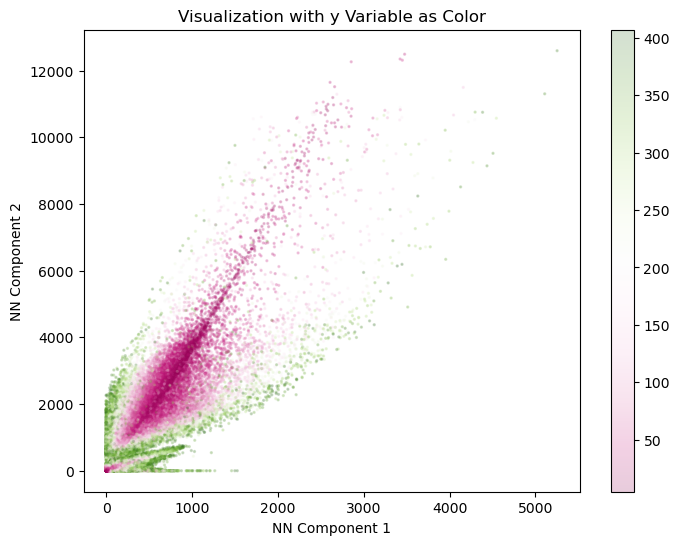

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_embbed[:, 0], X_test_embbed[:, 1], s=2, alpha=0.2, c=y_test_sum, cmap='PiYG')
plt.colorbar(scatter)
plt.title('Visualization with y Variable as Color')
plt.xlabel('NN Component 1')
plt.ylabel('NN Component 2')
plt.show()

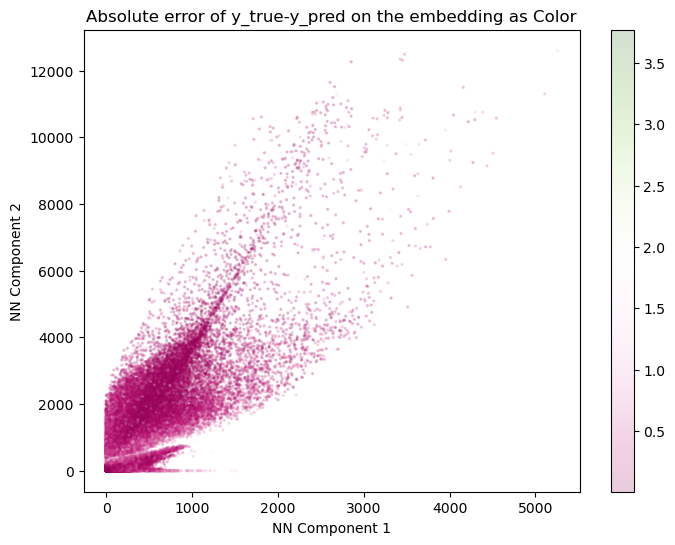

In [29]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test_embbed[:, 0], X_test_embbed[:, 1], s=2, alpha=0.2, c=err, cmap='PiYG')
plt.colorbar(scatter)
plt.title('Absolute error of y_true-y_pred on the embedding as Color')
plt.xlabel('NN Component 1')
plt.ylabel('NN Component 2')
plt.show()

# Get stupid points

In [33]:
embedd_df = feature_extractor(scaler_x.transform(df[x_columns]))

/Users/goncaloabreu/miniforge3/envs/simple-ml/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [37]:
df['embedd_1'], df['embedd_2'] = embedd_df[:,0], embedd_df[:,1]
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,y0,y1,y2,y3,y4,y5,y6,embedd_1,embedd_2
0,0.133438,-0.092950,0.011193,-0.005795,0.000771,-0.000122,-0.713354,0.129141,1.482134,0.213466,0.241207,0.475203,0.852697,1.067530,0.342066,6.467881,0.000000
1,0.106896,0.107480,0.007474,0.007549,0.000577,0.000333,-0.718440,-0.309748,1.711563,0.178743,0.181471,0.403228,0.821898,1.052911,0.333320,8.356662,2.843116
2,0.100286,0.098256,0.006654,0.006411,0.000179,0.000225,-0.775836,0.064299,1.895026,0.154513,0.204983,0.335392,0.807669,0.965668,0.331046,8.773594,3.137916
3,0.120435,0.114909,0.009287,0.008526,0.000167,0.000237,-0.767415,0.016524,1.380982,0.196482,0.304152,0.364896,0.833857,1.286199,0.337564,7.767463,2.226778
4,-0.128050,0.160498,0.009165,-0.010457,-0.000347,0.000200,-0.719544,0.569769,0.962259,0.304666,0.529468,0.435512,0.834355,1.311465,0.340612,5.801109,0.000000


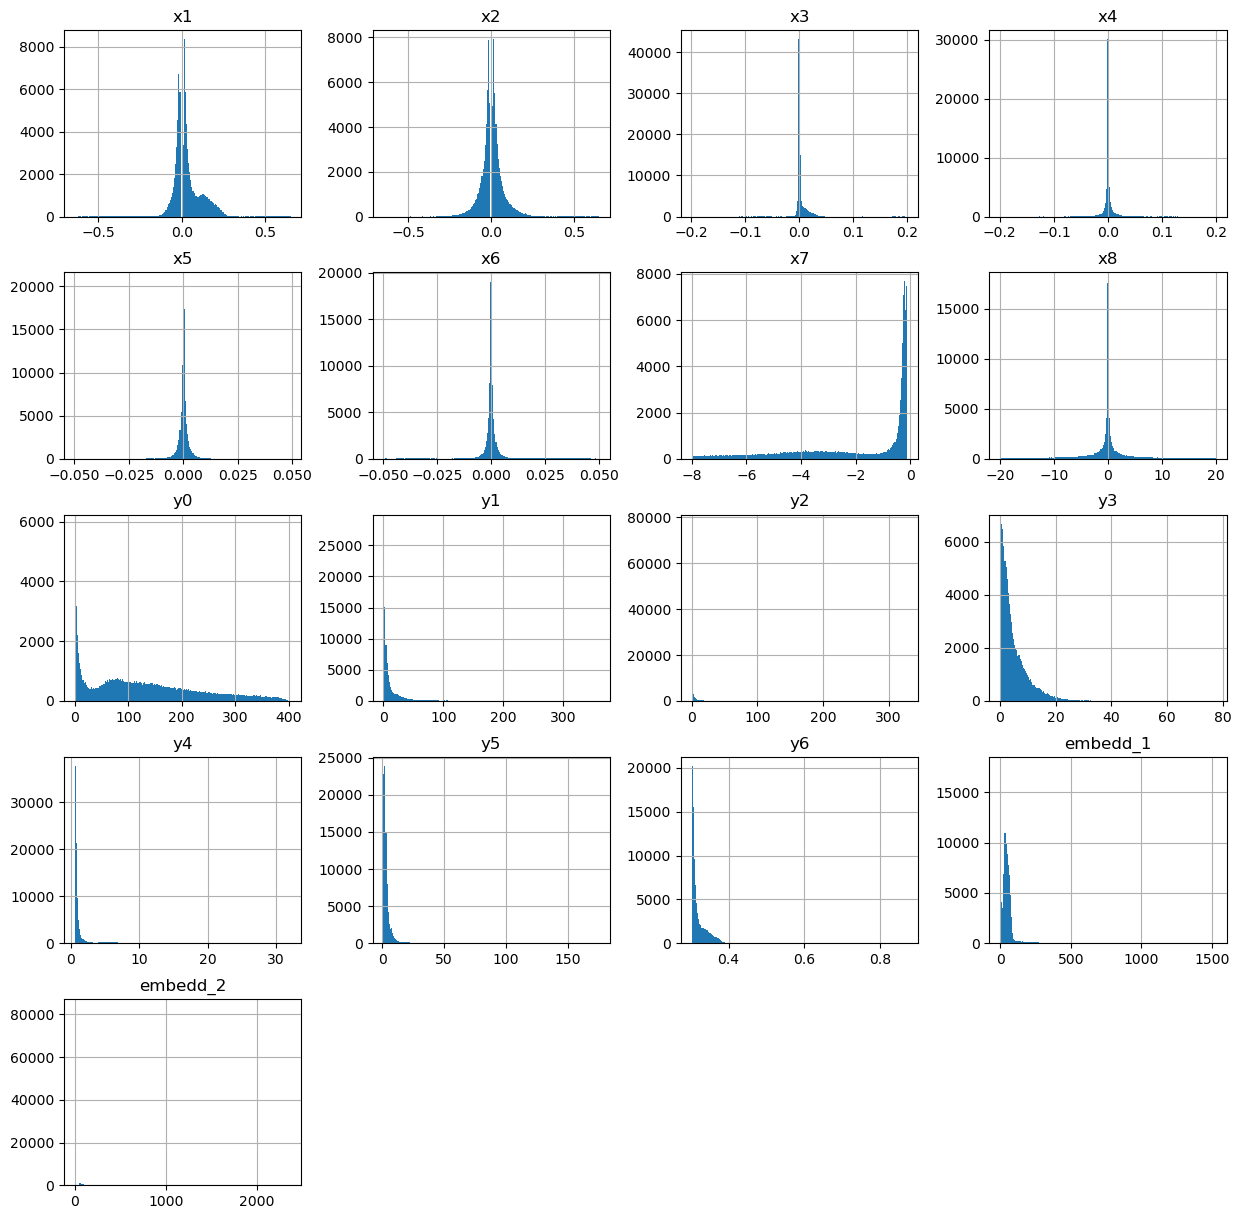

In [47]:
df.loc[(df['embedd_1'] == 0) | (df['embedd_2'] == 0)].hist(figsize=(15,15),bins=200);